# Under-Representation Bias (w/ Synthetic Data)

This notebook recreates the finding that Equalized Odds constrained model can recover from under-representation bias.

### Setup

Please run the code block below to install the necessary packages (if needed).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from collections import Counter

import fairlearn
from fairlearn.metrics import *
from fairlearn.reductions import *
import aif360

import copy, random

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Synthetic Dataset Generation

## Parameters (User Input)

In [2]:
'''

r is the proportion of training examples in the minority group, 

which means 1-r is proportion of examples in the majority group

eta is the probability of flipping the label

n is the number of training examples

beta is the probability of keeping a positively labeled example
from the minority class

NOTE: results can be replicated if and only if the following condition holds:

(1-r)(1-2*eta) + r((1-eta)*beta - eta) > 0

'''
def get_params(r = 1/3, eta = 1/4, n = 2000, beta = 0.5):
    return r, eta, n, beta

r, eta, n, beta = get_params(n = 20000)

In [3]:
# check if above constraint holds
def check_constraints(r, eta, beta):
    first = (1-r)*(1-2*eta)
    second = r * ((1-eta)*beta - eta)
    res = first + second
    print("constraint: ", res)
    print("yes!", r, eta, beta) if res > 0 else print("no", r, eta, beta)
    
bias_amts = np.divide(list(range(10, -1, -1)),10)

for beta in bias_amts:
    check_constraints(r, eta, beta)

constraint:  0.5
yes! 0.3333333333333333 0.25 1.0
constraint:  0.47500000000000003
yes! 0.3333333333333333 0.25 0.9
constraint:  0.45000000000000007
yes! 0.3333333333333333 0.25 0.8
constraint:  0.425
yes! 0.3333333333333333 0.25 0.7
constraint:  0.4
yes! 0.3333333333333333 0.25 0.6
constraint:  0.37500000000000006
yes! 0.3333333333333333 0.25 0.5
constraint:  0.35000000000000003
yes! 0.3333333333333333 0.25 0.4
constraint:  0.325
yes! 0.3333333333333333 0.25 0.3
constraint:  0.30000000000000004
yes! 0.3333333333333333 0.25 0.2
constraint:  0.275
yes! 0.3333333333333333 0.25 0.1
constraint:  0.25000000000000006
yes! 0.3333333333333333 0.25 0.0


## True Label Generation

In [4]:
# create minority and majority groups
def get_cat_features(n, r):
    num_minority = int(r * n)
    num_majority = n - num_minority
    
    minority = np.zeros((num_minority, 1))
    majority = np.ones((num_majority, 1))
    
    cat_features = np.vstack((minority, majority))
    
    # shuffle so as to ensure randomness
    np.random.shuffle(cat_features)
    
    return cat_features

In [5]:
# return labels from Bayes Optimal Classifier
def get_bayes_optimal_labels(features, effect_param):
    outcome_continuous = 1/(1+np.exp(-np.matmul(features, effect_param)))
    return np.where(outcome_continuous >= 0.5, 1, 0)

# flip labels with probability eta
def flip_labels(df_synthetic, eta):
    labels = df_synthetic['outcome']
    
    for i in range(len(labels)):
        if random.uniform(0,1) <= eta:
            labels[i] = 1 if labels[i] == 0 else 0
    df_synthetic['outcome'] = labels
    
    return df_synthetic

In [6]:
# ensure equal proportion of positive examples across minority and majority
def equal_base_rates(df_majority, df_minority):
    base_rate_maj = df_majority['outcome'].value_counts()[0] / len(df_majority)
    base_rate_min = df_minority['outcome'].value_counts()[0] / len(df_minority)
    
    X_maj_pos = df_majority[df_majority['outcome'] == 1].iloc[:, :].values
    X_maj_neg = df_majority[df_majority['outcome'] == 0].iloc[:, :].values
    
    diff = round(base_rate_maj,4) - round(base_rate_min,4)
    
    print(diff*100)
    
    count = 0
    
    if diff > 0:
        while(diff > 0.01):
            X_maj_neg = np.delete(X_maj_neg, 0, axis = 0)

            df_majority = pd.DataFrame(pd.DataFrame(np.vstack((X_maj_pos, X_maj_neg))))
            df_majority.columns = ['num1','num2','num3','cat','outcome']

            base_rate_maj = df_majority['outcome'].value_counts()[0] / len(df_majority)
            diff = round(base_rate_maj,4) - round(base_rate_min,4)
            count+=1

            # fail-safe
            if count > int(len(df_majority)/3): break
    else:
        diff = round(base_rate_min,4) - round(base_rate_maj,4) 
        while(diff > 0.01):
            X_maj_pos = np.delete(X_maj_pos, 0, axis = 0)

            df_majority = pd.DataFrame(pd.DataFrame(np.vstack((X_maj_pos, X_maj_neg))))
            df_majority.columns = ['num1','num2','num3','cat','outcome']

            base_rate_maj = df_majority['outcome'].value_counts()[0] / len(df_majority)
            diff = round(base_rate_min,4) - round(base_rate_maj,4) 
            count+=1

            # fail-safe
            if count > int(len(df_majority)/3): break
                
    total = np.vstack((df_majority, df_minority))
    
    # shuffle so as to ensure randomness
    np.random.shuffle(total)
                
    df_true = pd.DataFrame(pd.DataFrame(total))
    df_true.columns = ['num1','num2','num3','cat','outcome']
    
    print(diff*100)
    
    return df_true

In [7]:
'''

create synthetic data with:
    3 numerical features (Gaussian), 1 categorical (sensitive attribute) 
    logistic outcome model s.t. outcome = Indicator[logit(effect_param*features) >= 0.5]
    
create minority/majority groups according to r param

simulate Bayes Optimal Classifiers for minority and majority

flip labels according to eta param

ensure equal base rates (proportion of positive examples) across both groups

'''

def true_label_generation(r, eta, n):

    ''' 
    delete this variable to allow user to control percentage of positively labeled examples
    eg: let outcome_continuous >= 0.2 implies 80% positively labeled samples
    '''
    # causal effect params
    effect_param_min = [0.5, -0.2, 0.1] 
    effect_param_maj = [-0.7, 0.5, 1.5]
    
    num_min = int(n*r)
    num_maj = n - num_min

    # required: len(cat_probabilities) = n_cat_features
    n_cat_features = 2
    cat_probabilities = [0.5, 0.5] 

    # numerical feature params
    means = [0, 0, 0]
    cov_matrix = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

    # features
    cat_features = get_cat_features(r=r, n=n)
    num_features_min = np.random.multivariate_normal(means, cov_matrix, num_min)
    num_features_maj = np.random.multivariate_normal(means, cov_matrix, num_maj)

    num_features = np.concatenate((num_features_min, num_features_maj))

    # outcomes
    outcome_continuous_min = 1/(1+np.exp(-np.matmul(num_features_min,effect_param_min))) # logit model + no added noise
    outcome_continuous_maj = 1/(1+np.exp(-np.matmul(num_features_maj,effect_param_maj))) # logit model + no added noise
    outcome_binary_min = get_bayes_optimal_labels(features=num_features_min, effect_param=effect_param_min)
    outcome_binary_maj = get_bayes_optimal_labels(features=num_features_maj, effect_param=effect_param_maj)
    
    outcome = np.hstack((outcome_binary_min,outcome_binary_maj)).reshape(n,1)
    temp_data = np.hstack((num_features,cat_features, outcome))
    np.random.shuffle(temp_data) # randomly shuffle the data
    
    df_synthetic = pd.DataFrame(temp_data)
    df_synthetic.columns = ['num1','num2','num3','cat','outcome']
    
    df_majority = df_synthetic[df_synthetic['cat'] == 1]
    df_minority = df_synthetic[df_synthetic['cat'] == 0]
    
    df_synthetic = flip_labels(df_synthetic, eta)
    
    df_majority = df_synthetic[df_synthetic['cat'] == 1]
    df_minority = df_synthetic[df_synthetic['cat'] == 0]
    
    # df_synthetic = equal_base_rates(df_majority, df_minority)
    
    return df_synthetic 

df_synthetic = true_label_generation(r=r, eta=eta, n=n)

# Preparation

### Data Preprocessing

In [8]:
# split into train and test
df_train = df_synthetic.loc[range(0,int(len(df_synthetic)/2)), :]
# if original dataset has odd number of samples, remove 1 sample to be even
if (len(df_synthetic) % 2 == 1):
    df_test = df_synthetic.loc[range(int(len(df_synthetic)/2)+1, len(df_synthetic)), :]
else:
    df_test = df_synthetic.loc[range(int(len(df_synthetic)/2), len(df_synthetic)), :]

# format data
X_true = df_test.iloc[:, :-1].values
y_true = df_test.iloc[:, -1].values

sens_attrs_true = [df_test['cat']]

# Bias Injection

In [9]:
def under_sample(df_minority_positive, beta):
    X_min = df_minority_positive.iloc[:, :].values
    
    # keep each example with probability beta
    for i in range(len(X_min)):
        if random.uniform(0,1) > beta:
            X_min = np.delete(X_min, 0, axis=0)
    
    df_minority_positive = pd.DataFrame(pd.DataFrame(X_min))
    df_minority_positive.columns = ['num1','num2','num3','cat','outcome']
    return df_minority_positive

def get_biased_data(df_train, beta):
    df_majority = df_train[df_train['cat'] == 1]
    df_minority = df_train[df_train['cat'] == 0]
    
    # unfavored group with negative label
    df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

    # unfavored group with positive label (preferred)
    df_minority_positive = df_minority[df_minority['outcome'] == 1.0]
    
    # data frame without positively labeled examples from minority class
    df_total = pd.concat([df_majority, df_minority_negative])
    
    # under-sampling process
    df_undersampled = under_sample(df_minority_positive, beta)

    # combine undersampled and original favored class to create dataset
    df_concat = pd.concat([df_total,df_undersampled])
    
    return df_concat.sample(frac=1)

df_concat = get_biased_data(df_train, 0.5)

# for fairness measures later
df_sens = df_concat['cat']

# format data
X_bias = df_concat.iloc[:, :-1].values
y_bias = df_concat.iloc[:, -1].values

# Model

### Model Selection + Training (TODO: modularize)

In [10]:
classifier = LogisticRegression(random_state=42)

classifier_bias = classifier.fit(X_bias, y_bias)
y_pred_bias = classifier_bias.predict(X_bias)
y_pred_bias_on_true = classifier_bias.predict(X_true)

### Model Performance (TODO: modularize)

In [36]:
# return accuracy of bayes optimal model on a given dataframe
def bayes_optimal_accuracy(df):
    
    # need to exclude outcome and categorical variables
    X_maj = df[df['cat'] == 1].iloc[:, :-2].values
    y_maj_true = df[df['cat'] == 1].iloc[:, -1].values
    effect_param_maj = [-0.7, 0.5, 1.5]

    X_min = df[df['cat'] == 0].iloc[:, :-2].values
    y_min_true = df[df['cat'] == 0].iloc[:, -1].values
    effect_param_min = [0.5, -0.2, 0.1] 

    pred_maj_labels = get_bayes_optimal_labels(X_maj, effect_param_maj).reshape(len(X_maj), 1)
    pred_min_labels = get_bayes_optimal_labels(X_min, effect_param_min).reshape(len(X_min), 1)

    accuracy_maj = accuracy_score(y_pred=pred_maj_labels, y_true=y_maj_true)
    accuracy_min = accuracy_score(y_pred=pred_min_labels, y_true=y_min_true)
    
    accuracy_bayes = np.mean([accuracy_maj, accuracy_min])
    
    return accuracy_bayes, accuracy_maj, accuracy_min

In [37]:
print("Synthetic Data\n")

bayes, maj, minor = bayes_optimal_accuracy(df_test)
print("Accuracy of Bayes Optimal Model on Ground Truth Data (Avg): ", bayes)
print("Accuracy of Bayes Optimal Model on Ground Truth Data (Maj): ", maj)
print("Accuracy of Bayes Optimal Model on Ground Truth Data (Min): ", minor)
print("Accuracy of Biased Model on Biased Data: ", accuracy_score(y_pred_bias, y_bias))
print("Accuracy of Biased Model on Ground Truth Data: ", accuracy_score(y_pred_bias_on_true, y_true))

Synthetic Data

Accuracy of Bayes Optimal Model on Ground Truth Data (Avg):  0.5993588355654584
Accuracy of Bayes Optimal Model on Ground Truth Data (Maj):  0.6482172161718633
Accuracy of Bayes Optimal Model on Ground Truth Data (Min):  0.5505004549590536
Accuracy of Biased Model on Biased Data:  0.6326486251494403
Accuracy of Biased Model on Ground Truth Data:  0.5901


# Evaluation

### Bias vs Accuracy vs Fairness Trade-Off

In [13]:
# if verbose, shows "Finished iteration: ... "
def tradeoff_visualization(classifier, X_true, y_true, df_train,
                           sensitive_feature = "cat",
                           apply_fairness = False, verbose = False):
    
    # 0 to 1 in increments of 0.1
    #bias_amts = np.divide(list(range(0,11)),10)
    bias_amts = np.divide(list(range(10,-1,-1)),10)
    accuracy_on_true = []
    accuracy_on_biased = []
    bayes_accuracy_on_biased = []
    accuracy_on_true_mitigated = []
    accuracy_on_biased_mitigated = []
    
    count = 0

    for beta in bias_amts:
        
        df_train_copy = df_train.copy()
        
        df_majority = df_train_copy[df_train_copy['cat'] == 1]
        df_minority = df_train_copy[df_train_copy['cat'] == 0]

        # unfavored group with negative label
        df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

        # unfavored group with positive label (preferred)
        df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

        # data frame without positively labeled examples from minority class
        df_total = pd.concat([df_majority, df_minority_negative])

        # under-sampling process
        df_undersampled = under_sample(df_minority_positive, beta)
        print("Num Minority Pos: ", len(df_undersampled))

        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_total,df_undersampled])
        
        bayes_accuracy_on_biased.append(bayes_optimal_accuracy(df_concat))
        
        df_sens = df_concat[sensitive_feature]

        # format data
        X_bias_true = df_concat.iloc[:, :-1].values
        y_bias_true = df_concat.iloc[:, -1].values

        classifier_bias = classifier.fit(X_bias_true, y_bias_true)
        
        if apply_fairness:
            constraint = EqualizedOdds()
            classifier_mitigated_bias = ExponentiatedGradient(classifier_bias, constraint)
            classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
            
            # testing on biased data WITH fairness intervention
            y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)
            
            # testing on GT data WITH fairness intervention
            y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)
        
        # testing on biased data withOUT fairness intervention
        y_pred_bias = classifier_bias.predict(X_bias_true)
        
        # testing on GT data withOUT fairness intervention
        y_pred_bias_on_true = classifier_bias.predict(X_true)

        # model performance
        
        if apply_fairness:
            # on biased data
            acc_bias_mitigated = accuracy_score(y_pred=y_pred_mitigated_bias, y_true=y_bias_true)
            accuracy_on_biased_mitigated.append(acc_bias_mitigated)
            
            # on GT data
            acc_bias_mitigated_on_true = accuracy_score(y_pred=y_pred_mitigated_bias_on_true, y_true=y_true)
            accuracy_on_true_mitigated.append(acc_bias_mitigated_on_true)
        
        # on biased data
        acc_bias = accuracy_score(y_pred=y_pred_bias, y_true=y_bias_true)
        accuracy_on_biased.append(acc_bias)
        # on GT data
        acc_bias_on_true = accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)
        accuracy_on_true.append(acc_bias_on_true)
        
        if verbose:
            print("Finished Iteration: ", count)
            count +=1
        
        # fail-safe
        if count > 30:
            break

    return bias_amts, accuracy_on_biased, accuracy_on_true, \
           accuracy_on_biased_mitigated, accuracy_on_true_mitigated, bayes_accuracy_on_biased

### Error Bars with Multiple Iterations

In [132]:
# if verbose, shows "Finished iteration: ... "
def tradeoff_visualization_error(classifier, X_true, y_true, df_train,
                           sensitive_feature = "cat",
                           apply_fairness = False, verbose = False, num_iters = 10):
    
    total_accuracy_on_true = []
    total_accuracy_on_biased = []
    total_accuracy_on_true_mitigated = []
    total_accuracy_on_biased_mitigated = []
    total_bayes_accuracy_on_true = []
    total_bayes_accuracy_on_true_maj = []
    total_bayes_accuracy_on_true_min = []
    bayes_accuracy_on_true = []
    bayes_accuracy_on_true_maj = []
    bayes_accuracy_on_true_min = []
    
    for i in range(num_iters):
    
        # 0 to 1 in increments of 0.1
        bias_amts = np.divide(list(range(10,-1,-1)),10)
        accuracy_on_true = []
        accuracy_on_biased = []
        accuracy_on_true_mitigated = []
        accuracy_on_biased_mitigated = []
        bayes_temp = []
        bayes_temp_maj = []
        bayes_temp_min = []

        count = 0
        
        df_synthetic = true_label_generation(r=r, eta=eta, n=n)
        
        # split into train and test
        df_train = df_synthetic.loc[range(0,int(len(df_synthetic)/2)), :]
        # if original dataset has odd number of samples, remove 1 sample to be even
        if (len(df_synthetic) % 2 == 1):
            df_test = df_synthetic.loc[range(int(len(df_synthetic)/2)+1, len(df_synthetic)), :]
        else:
            df_test = df_synthetic.loc[range(int(len(df_synthetic)/2), len(df_synthetic)), :]

        # format data
        X_true = df_test.iloc[:, :-1].values
        y_true = df_test.iloc[:, -1].values
        
        # bayes optimal classifier accuracy on ground truth data
        bayes, bayes_maj, bayes_min = bayes_optimal_accuracy(df_test)
        bayes_accuracy_on_true_maj.append(bayes_maj)
        bayes_accuracy_on_true_min.append(bayes_min)
        bayes_accuracy_on_true.append(bayes)

        sens_attrs_true = [df_test['cat']]

        for beta in bias_amts:

            df_train_copy = df_train.copy()

            df_majority = df_train_copy[df_train_copy['cat'] == 1]
            df_minority = df_train_copy[df_train_copy['cat'] == 0]

            # unfavored group with negative label
            df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

            # unfavored group with positive label (preferred)
            df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

            # data frame without positively labeled examples from minority class
            df_total = pd.concat([df_majority, df_minority_negative])

            # under-sampling process
            df_undersampled = under_sample(df_minority_positive, beta)
            #print("Num Minority Pos: ", len(df_undersampled))

            # combine undersampled and original favored class to create dataset
            df_concat = pd.concat([df_total,df_undersampled])

            df_sens = df_concat[sensitive_feature]

            # format data
            X_bias_true = df_concat.iloc[:, :-1].values
            y_bias_true = df_concat.iloc[:, -1].values

            classifier_bias = classifier.fit(X_bias_true, y_bias_true)

            if apply_fairness:
                constraint = EqualizedOdds()
                classifier_mitigated_bias = ExponentiatedGradient(classifier_bias, constraint)
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)

                # testing on biased data WITH fairness intervention
                y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)

                # testing on GT data WITH fairness intervention
                y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)

            # testing on biased data withOUT fairness intervention
            y_pred_bias = classifier_bias.predict(X_bias_true)

            # testing on GT data withOUT fairness intervention
            y_pred_bias_on_true = classifier_bias.predict(X_true)

            # model performance

            if apply_fairness:
                # on biased data
                acc_bias_mitigated = accuracy_score(y_pred=y_pred_mitigated_bias, y_true=y_bias_true)
                accuracy_on_biased_mitigated.append(acc_bias_mitigated)

                # on GT data
                acc_bias_mitigated_on_true = accuracy_score(y_pred=y_pred_mitigated_bias_on_true, y_true=y_true)
                accuracy_on_true_mitigated.append(acc_bias_mitigated_on_true)

            # on biased data
            acc_bias = accuracy_score(y_pred=y_pred_bias, y_true=y_bias_true)
            accuracy_on_biased.append(acc_bias)
            # on GT data
            acc_bias_on_true = accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)
            accuracy_on_true.append(acc_bias_on_true)
            
            bayes_temp.append(bayes)
            bayes_temp_maj.append(bayes_maj)
            bayes_temp_min.append(bayes_min)
            

            if verbose:
                print("Finished Iteration: ", count)
                count +=1

            # fail-safe
            if count > 30:
                break
        
        total_accuracy_on_biased.append(accuracy_on_biased)
        total_accuracy_on_biased_mitigated.append(accuracy_on_biased_mitigated)
        total_accuracy_on_true.append(accuracy_on_true)
        total_accuracy_on_true_mitigated.append(accuracy_on_true_mitigated)
        total_bayes_accuracy_on_true.append(bayes_temp)
        total_bayes_accuracy_on_true_maj.append(bayes_temp_maj)
        total_bayes_accuracy_on_true_min.append(bayes_temp_min)
        
        if verbose:
                print("Finished Total Iteration: ", i+1)
    
        
    mean_biased = np.mean(total_accuracy_on_biased, axis = 0)
    mean_biased_mitigated = np.mean(total_accuracy_on_biased_mitigated, axis = 0)
    mean_true = np.mean(total_accuracy_on_true, axis = 0)
    mean_true_mitigated = np.mean(total_accuracy_on_true_mitigated, axis = 0)
    mean_bayes_accuracy_on_true = np.mean(total_bayes_accuracy_on_true, axis = 0)
    mean_bayes_accuracy_on_true_maj = np.mean(total_bayes_accuracy_on_true_maj, axis = 0)
    mean_bayes_accuracy_on_true_min = np.mean(total_bayes_accuracy_on_true_min, axis = 0)
    
    y_err_biased = np.std(total_accuracy_on_biased, axis = 0)
    y_err_biased_mitigated = np.std(total_accuracy_on_biased_mitigated, axis = 0)
    y_err_true = np.std(total_accuracy_on_true, axis = 0)
    y_err_true_mitigated = np.std(total_accuracy_on_true_mitigated, axis = 0)


    return bias_amts, mean_biased, mean_true, \
           mean_biased_mitigated, mean_true_mitigated, y_err_biased, \
           y_err_true, y_err_biased_mitigated, y_err_true_mitigated, \
           mean_bayes_accuracy_on_true, mean_bayes_accuracy_on_true_maj, \
           mean_bayes_accuracy_on_true_min

In [133]:
def accuracy_visualizations(bias_amts, accuracy_on_biased = [], accuracy_on_true = [],
                            accuracy_on_biased_mitigated = [],
                            accuracy_on_true_mitigated = [], fairness = False):
    plt.figure(figsize=(10,7))
    if fairness:
        plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Biased Data')
        plt.xlim(1.05, -0.05)
        plt.xlabel("Beta Value")
        plt.ylabel("Accuracy Score")
        plt.title("Biased Model Accuracy")
        plt.legend()

        plt.show()
        
    else:
        plt.plot(bias_amts, accuracy_on_true, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased, label = 'Biased Data')
        plt.xlim(1.05, -0.05)
        plt.xlabel("Beta Value")
        plt.ylabel("Accuracy Score")
        plt.title("Biased Model Accuracy")
        plt.legend()

        plt.show()

In [134]:
def total_visualizations(bias_amts, mean_biased, mean_true,
                        mean_biased_mitigated, mean_true_mitigated):
    plt.figure(figsize=(10,7))
    plt.errorbar(bias_amts, mean_biased, yerr= y_err_biased, label = 'Tested On Biased Data + No Fairness Intervention', color = "red")
    plt.errorbar(bias_amts, mean_biased_mitigated, yerr= y_err_biased_mitigated, label = 'Tested On Biased Data + Fairness Intervention', color = "green")
    plt.errorbar(bias_amts, mean_true, yerr= y_err_true, label = 'Tested On Ground Truth + No Fairness Intervention', color = "blue")
    plt.errorbar(bias_amts, mean_true_mitigated, yerr= y_err_true_mitigated, label = 'Tested On Ground Truth + Fairness Intervention', color = "purple")
    #plt.plot(bias_amts, bayes_accuracy_on_biased, label = 'Bayes Optimal Model On Biased Data', color = "black")
    #plt.axhline(y = bayes_optimal_accuracy(df_test), label = "Bayes Optimal Model On Ground Truth Data", color = "pink")
    plt.xlim(1.05, -0.05)
    plt.xlabel("Beta Value")
    plt.ylabel("Accuracy Score")
    plt.title("Accuracy of Biased Model (trained on biased data)")
    #plt.legend(loc = 1)
    plt.legend()
    plt.show()

In [135]:
classifier = LogisticRegression()

bias_amts, mean_biased, mean_true, \
           mean_biased_mitigated, mean_true_mitigated, y_err_biased, \
           y_err_true, y_err_biased_mitigated, y_err_true_mitigated, \
           mean_bayes_accuracy_on_true, mean_bayes_accuracy_on_true_maj, \
           mean_bayes_accuracy_on_true_min = \
tradeoff_visualization_error(classifier, X_true=X_true, y_true=y_true, \
                       df_train=df_train, sensitive_feature="cat", \
                       apply_fairness=True,verbose=True, num_iters=10)

Finished Iteration:  0
Finished Iteration:  1
Finished Iteration:  2
Finished Iteration:  3
Finished Iteration:  4
Finished Iteration:  5
Finished Iteration:  6
Finished Iteration:  7
Finished Iteration:  8
Finished Iteration:  9
Finished Iteration:  10
Finished Total Iteration:  1
Finished Iteration:  0
Finished Iteration:  1
Finished Iteration:  2


/Users/manishn/Library/Python/3.7/lib/python/site-packages/fairlearn/reductions/_exponentiated_gradient/_lagrangian.py:133: OptimizeWarning: The pivot operation produces a pivot value of: 3.1e-06, which is only slightly greater than the specified tolerance 1.0e-09. This may lead to issues regarding the numerical stability of the simplex method. Removing redundant constraints, changing the pivot strategy via Bland's rule or increasing the tolerance may help reduce the issue.
  result = opt.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, method='simplex')
/Users/manishn/Library/Python/3.7/lib/python/site-packages/fairlearn/reductions/_exponentiated_gradient/_lagrangian.py:133: OptimizeWarning: The pivot operation produces a pivot value of: 3.1e-06, which is only slightly greater than the specified tolerance 1.0e-09. This may lead to issues regarding the numerical stability of the simplex method. Removing redundant constraints, changing the pivot strategy via Bland's rule or increa

Finished Iteration:  3
Finished Iteration:  4
Finished Iteration:  5
Finished Iteration:  6
Finished Iteration:  7
Finished Iteration:  8
Finished Iteration:  9
Finished Iteration:  10
Finished Total Iteration:  2
Finished Iteration:  0
Finished Iteration:  1
Finished Iteration:  2
Finished Iteration:  3
Finished Iteration:  4
Finished Iteration:  5
Finished Iteration:  6
Finished Iteration:  7
Finished Iteration:  8
Finished Iteration:  9
Finished Iteration:  10
Finished Total Iteration:  3
Finished Iteration:  0
Finished Iteration:  1
Finished Iteration:  2
Finished Iteration:  3
Finished Iteration:  4
Finished Iteration:  5
Finished Iteration:  6
Finished Iteration:  7
Finished Iteration:  8
Finished Iteration:  9
Finished Iteration:  10
Finished Total Iteration:  4
Finished Iteration:  0
Finished Iteration:  1
Finished Iteration:  2
Finished Iteration:  3
Finished Iteration:  4
Finished Iteration:  5
Finished Iteration:  6
Finished Iteration:  7
Finished Iteration:  8
Finished Iter

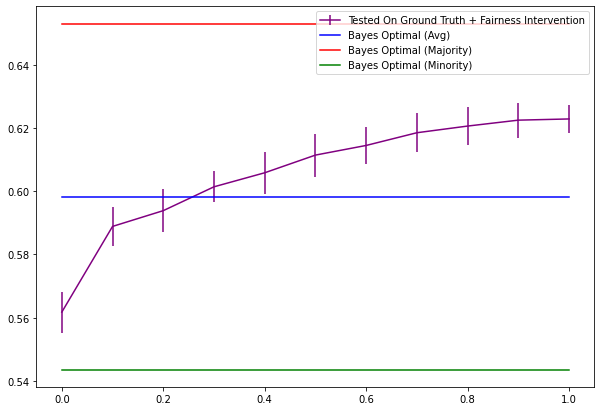

In [141]:
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, mean_true_mitigated, yerr= y_err_true_mitigated, label = 'Tested On Ground Truth + Fairness Intervention', color = "purple")
plt.errorbar(bias_amts, mean_bayes_accuracy_on_true, label = 'Bayes Optimal (Avg)', color = 'blue')
plt.errorbar(bias_amts, mean_bayes_accuracy_on_true_maj, label = 'Bayes Optimal (Majority)', color = 'red')
plt.errorbar(bias_amts, mean_bayes_accuracy_on_true_min, label = 'Bayes Optimal (Minority)', color = 'green')
plt.legend()
plt.show()

In [137]:
# without fairness intervention
#accuracy_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
#                        accuracy_on_biased_mitigated, accuracy_on_true_mitigated, False, beta)

In [138]:
# with fairness intervention
#accuracy_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
#                        accuracy_on_biased_mitigated, accuracy_on_true_mitigated, True, beta)

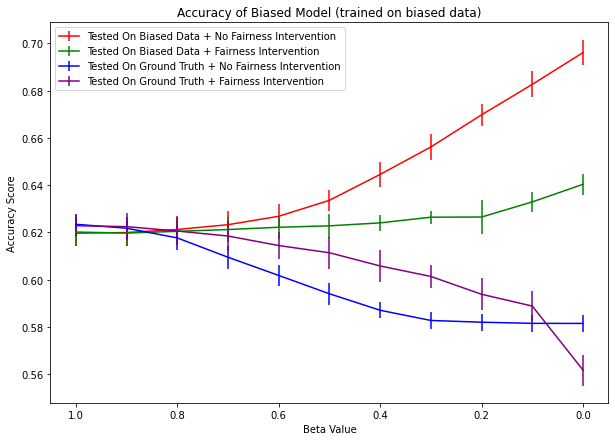

In [139]:
total_visualizations(bias_amts, mean_biased, mean_true,
                    mean_biased_mitigated, mean_true_mitigated)